Goal: Investigate the effect of different factors on the dmv test scores
1. time spent doing the test: duration (min)
2. risk score associated with the ip address used as determined my scamalytics

Methods:
Heat map charts.
Covariance tests.

In [1]:
%matplotlib notebook

In [2]:
# Gather modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
import os
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from collections import Counter
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import mywhois
import dmv_test_input


In [3]:
# displot_xy: Heatmap plot showing the variation of two columns. 
def displot_xy(df, 
               base="TotalQuestionsCorrect", # Appear on x-axis
               compare="duration",           # y-axis
               suspect=True,                 # Show suspects duratios<fastest
               fastest=12,                   # Limit on duration 
               nminor = 1,                   # y=axis minor ticks
               col_order = None, 
               row_order = None,
               aspect = 2,
               bins=10):                     # Bins to use on both axes
    
    # By default, x=total questions answered correctly by y=time to answer
    
    df["suspect"] = df.duration.apply(lambda x: "suspect" if x <= fastest else "not suspected")
    
    case = "suspect" if suspect else "not suspected"
    sns.set(rc={'figure.figsize':(11, 8.5)})
    g = sns.displot(data=df[df.suspect==case], x=base, y=compare, 
                palette='autumn',
                bins=bins, 
                cbar=True,
                col_order = col_order,
                row_order = row_order,
                aspect = aspect,
               )
    g.ax.yaxis.set_minor_locator(AutoMinorLocator(nminor + 1))
    plt.title(f"{base} vs {compare} {' <= ' if case=='suspected' else ' < '}{fastest} min ")

In [4]:
# displot_xy_hue: Variation of displot_xy shows effect of two factors.
def displot_xy_hue(df, 
                   base="TotalQuestionsCorrect", 
                   compare="duration", 
                   hue="risk",
                   suspect=True, 
                   fastest=12, 
                   bw_adjust=0.9, 
                   nminor = 1,
                   col_order = None, 
                   row_order = None,
                   palette="winter",
                   bins=10):
    
    # The extra factor is assigned to hue. 
    # By default, TotalQuestionsCorrect is plotted vs duration and risk

    df["suspect"] = df.duration.apply(lambda x: "suspect" if x <= fastest else "not suspected")
    
    case = "suspect" if suspect else "not suspected"

    sns.set_style("whitegrid")
    g = sns.displot(data=df[df.suspect==case], x=base, y=compare, 
                    hue=hue,
                    palette=palette,
                    bins=bins, 
                    cbar=True,
                    col_order = col_order,
                    row_order = row_order,
                    aspect = 3,
                   )
    g.ax.yaxis.set_minor_locator(AutoMinorLocator(nminor + 1))
    plt.title(f"{base} vs {compare} {' <= ' if case=='suspected' else ' < '}{fastest} min ")

In [5]:

# def prep_dmv_sample(raw_dataframe, save=False, filename="clean_test_data.csv"):
#     # Data prep from sample downloaded from web site database

#     original_length = len(raw_dataframe)
#     print(f"Original length of sample data is {original_length}")

#     # Drop data with Result.isna(). These events also have TotalScore=0, IPAddress.isna().
#     # - Show them using: df[df["Result"].isna()]
#     # - rest_index() is needed after the rows are dropped

#     df = raw_dataframe.dropna(axis=0, subset=["Result"]).reset_index(drop=True)

#     dropped_nan = original_length - len(df)
#     print(f"{dropped_nan} tests with Result, IPAddress, TotalScore = NaN dropped")

#     # Add column, ip, with the port number from the reported ip address
#     df["ip"] = df.IPAddress.apply(lambda x: x.split(":")[0])

#     # Add column, duration, for the TotalTimeSpent in minutes
#     df["duration"] = df.TotalTimeSpent/60    

#     # Add column, duration, for the TotalTimeSpent in minutes
#     df["duration"] = df.TotalTimeSpent/60

#     # Some events have more than 1 ip address
#     df["multiple_ip"] = df.ip.apply( lambda x: len(x.split(","))>1)

#     # Remove the extra ip address from tests with more than 1 ip address
#     df.loc[:,"ip"] = df.ip.apply(lambda x: x.split(",")[0])
#     print(f'Extra ip address dropped in {len(df[df["multiple_ip"]])} tests')
    
#     # Make a copy of the cleaned data
#     if save:
#         df.to_csv("clean_test_data.csv", index=False)
#     return df

In [6]:
# Input data
sample_filename = "/home/bkrawchuk/notebooks/dmv_test/OPT11022021-11042021.csv"

# Read the sample data downloaded from the DMV testing web site
test_sample = pd.read_csv(sample_filename)

# Work with a shallow copy
raw_dataframe = test_sample.copy()

In [7]:
df = dmv_test_input.prep_dmv_sample(raw_dataframe, save=True)

Original length of sample data is 4561
110 tests with Result, IPAddress, TotalScore = NaN dropped
Extra ip address dropped in 36 tests


In [8]:
# Add the risk associated while using the client's ip address
risk = mywhois.Risk("mywhois", readonly=True)

def fetch_score(ip):
    # Fetch the risk score associated with this ip address
    # Return as float so it can be used numerically
    r = risk.find(ip)
    if r:
        return float(r["score"])
    return -1

def fetch_risk(ip):
    # Fetch the risk discriptor
    r = risk.find(ip)
    if r:
        return r["risk"]
    return "Unknown"

vscore = df.loc[:,"ip"].apply(fetch_score).copy()
vrisk  = df.loc[:,"ip"].apply(fetch_risk).copy()
df.loc[:,"risk"]  = vrisk
df.loc[:,"score"] = vscore

In [9]:
# Construct an uneven range of percentiles
# d_range = [0, .05, .1, .15, .2, .25, .35, .4, .6, .8, 1]
d_range = np.arange(0, 1.05, 0.05)  # np.linspace(start, stop, num=50, ...)
# A set of labels to make it easier to read chart
d_label = [f"pct{round(100*x):02d}" for x in d_range[:-1]]
df["duration_interval"] = pd.qcut(df.duration, d_range)
df["duration_label"] = pd.qcut(df.duration, d_range, labels=d_label)


for i, x in enumerate(sorted(list(set(df.duration_interval)))):
    print(f"{d_label[i]}  {x.left: >7.3f}  {x.right:>7.3f}")


pct00    2.516    8.167
pct05    8.167   10.583
pct10   10.583   12.442
pct15   12.442   14.067
pct20   14.067   16.000
pct25   16.000   17.567
pct30   17.567   19.192
pct35   19.192   20.850
pct40   20.850   22.375
pct45   22.375   24.067
pct50   24.067   25.800
pct55   25.800   27.683
pct60   27.683   29.700
pct65   29.700   32.133
pct70   32.133   34.783
pct75   34.783   37.767
pct80   37.767   41.375
pct85   41.375   46.400
pct90   46.400   55.300
pct95   55.300  130.400


In [10]:
# Check that they look correct in the dataframe
df[["duration", "duration_label", "duration_interval"]]

,duration,duration_label,duration_interval
0,22.983333,pct45,"(22.375, 24.067]"
1,16.016667,pct25,"(16.0, 17.567]"
2,15.500000,pct20,"(14.067, 16.0]"
3,22.400000,pct45,"(22.375, 24.067]"
4,46.433333,pct90,"(46.4, 55.3]"
...,...,...,...
4446,23.033333,pct45,"(22.375, 24.067]"
4447,20.500000,pct35,"(19.192, 20.85]"
4448,13.950000,pct15,"(12.442, 14.067]"
4449,10.966667,pct10,"(10.583, 12.442]"


<IPython.core.display.Javascript object>


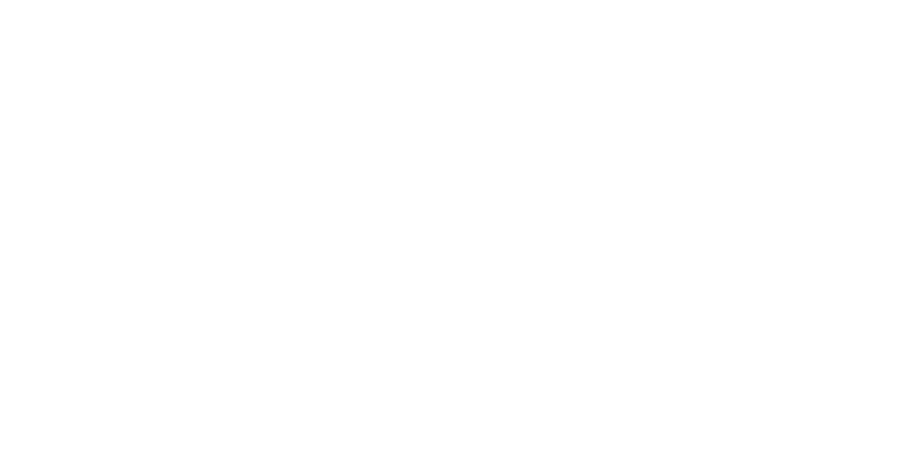

pct00  [  2.516 -   8.167 )
pct05  [  8.167 -  10.583 )
pct10  [ 10.583 -  12.442 )
pct15  [ 12.442 -  14.067 )
pct20  [ 14.067 -  16.000 )
pct25  [ 16.000 -  17.567 )
pct30  [ 17.567 -  19.192 )
pct35  [ 19.192 -  20.850 )
pct40  [ 20.850 -  22.375 )
pct45  [ 22.375 -  24.067 )
pct50  [ 24.067 -  25.800 )
pct55  [ 25.800 -  27.683 )
pct60  [ 27.683 -  29.700 )
pct65  [ 29.700 -  32.133 )
pct70  [ 32.133 -  34.783 )
pct75  [ 34.783 -  37.767 )
pct80  [ 37.767 -  41.375 )
pct85  [ 41.375 -  46.400 )
pct90  [ 46.400 -  55.300 )
pct95  [ 55.300 - 130.400 )


In [11]:
displot_xy(df, base="TotalQuestionsCorrect", compare="duration_label", fastest=1000, aspect=2)
for i, x in enumerate(sorted(list(set(df.duration_interval)))):
    print(f"{d_label[i]}  [{x.left: >7.3f} - {x.right:>7.3f} )")


<IPython.core.display.Javascript object>


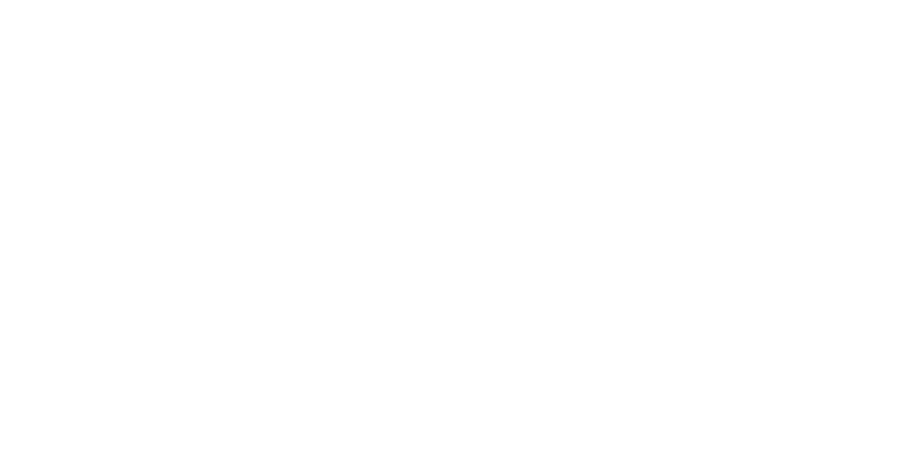

In [12]:
displot_xy(df, base="TotalQuestionsCorrect", compare="duration", fastest=40, aspect=2)


<IPython.core.display.Javascript object>


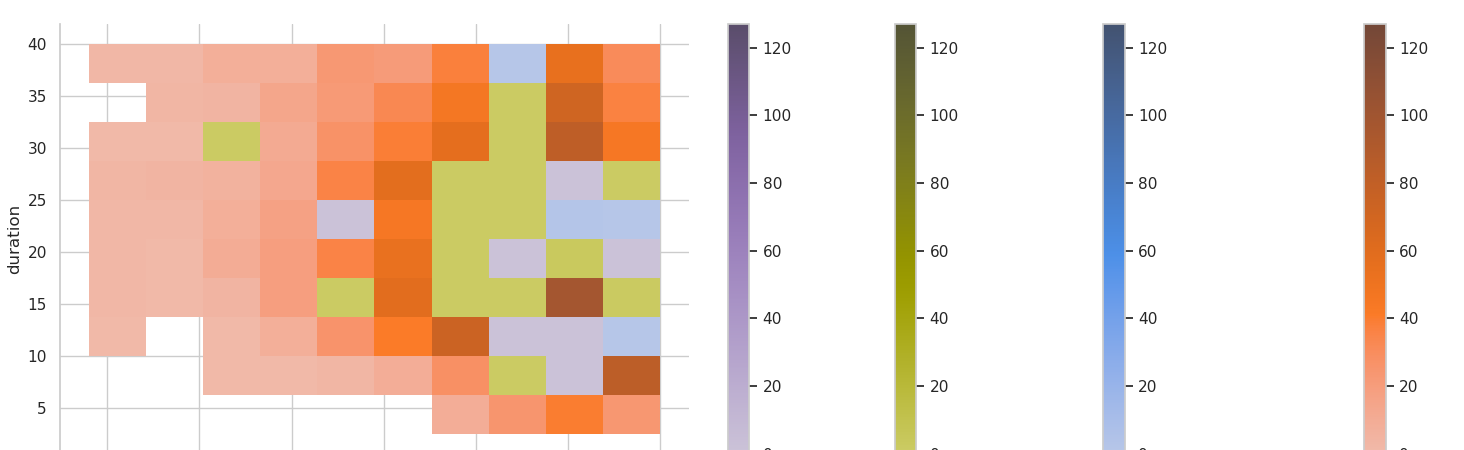

In [13]:
displot_xy_hue(df, base="TotalQuestionsCorrect", compare="duration", fastest=40, hue="risk", palette="Accent_r")


<IPython.core.display.Javascript object>


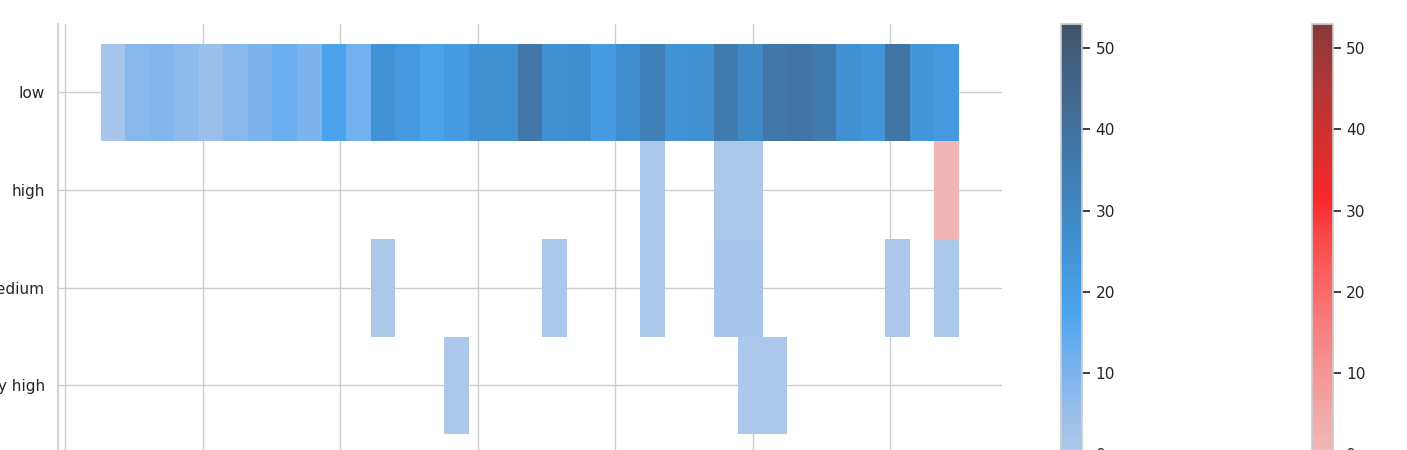

In [14]:
displot_xy_hue(df, base="duration", compare="risk", hue="Result", fastest=15, bins=35, palette="Set1")


From the graphs above:
1. A larger rate p/f before 15 than after 15m. 
2. There are peaks of the success rate at 10 minutes and 22 minutes. To hazard a guess the normal passing test takers use about 22 minutes. Perhaps those around 10 minutes are cheaters.
3. High risk ip's were used to at 7-8 minutes.

It's thought that people must be cheating if they are passing in a short period of time. DMV originally said 5 minutes. The histogram of test duration showed two peaks, one at 

The following is a correlation study to see if the variation of the time the test took to finish (duration) or the risk associated with the ip address used by the test taker (score) affects the score obtained during the test (TotalScore). There is also a test of the Height of the test taker to act as a control. There should be no correlation between Height and TotalScore.

In [15]:
def run_correlation_tests(w, c1, c2):
    print(f"\nCompare {c1} and {c2}:")
    x = f"{np.cov(w[c1], w[c2])}".replace('\n', ', ')
    print(f"Covariance: {x}")
    print(f"Pearson:    {pearsonr(w[c1], w[c2])}")
    print(f"{spearmanr(w[c1], w[c2])}")

w = df
run_correlation_tests(w, "TotalScore", "duration")
run_correlation_tests(w, "TotalScore", "score")
w = df[["TotalScore", "Height"]].dropna()
run_correlation_tests(w, "TotalScore", "Height")
    



Compare TotalScore and duration:
Covariance: [[ 28.01487912  -7.09766075],  [ -7.09766075 224.58878106]]
Pearson:    (-0.0894801764109038, 2.230491066966477e-09)
SpearmanrResult(correlation=-0.11024083110923663, pvalue=1.64062316517206e-13)

Compare TotalScore and score:
Covariance: [[28.01487912  2.72172283],  [ 2.72172283 77.63552056]]
Pearson:    (0.05836053775686735, 9.787600030751117e-05)
SpearmanrResult(correlation=0.04200586060209567, pvalue=0.005064455516367159)

Compare TotalScore and Height:
Covariance: [[28.01487912  0.6857963 ],  [ 0.6857963  16.80770204]]
Pearson:    (0.03160433016653797, 0.03499268055584542)
SpearmanrResult(correlation=0.015577747415642417, pvalue=0.2987799696421343)


The Pearson correlation coefficient indicates the correlation is weak in all 3 cases. The results are consistent with those for Height verifying the weak correlation.

The Spearman result shows a little more correlation but still far away from the range \[0.5, 1) needed to confirm correlation. The Spearman correlation is to show non-linear correlation

In [16]:
# Focus on tests with shorter duration
duration_min = 20
short = df[df.duration <= duration_min]

w = short
run_correlation_tests(w, "TotalScore", "duration")
run_correlation_tests(w, "TotalScore", "score")
w = short[["TotalScore", "Height"]].dropna()
run_correlation_tests(w, "TotalScore", "Height")
    



Compare TotalScore and duration:
Covariance: [[24.05770243 -5.76045378],  [-5.76045378 17.85129294]]
Pearson:    (-0.27796798796530425, 6.652935635760503e-31)
SpearmanrResult(correlation=-0.2674249330150529, pvalue=1.2065411549772668e-28)

Compare TotalScore and score:
Covariance: [[24.05770243  2.20344301],  [ 2.20344301 85.95512592]]
Pearson:    (0.04845502891316154, 0.048125265027109336)
SpearmanrResult(correlation=0.04483165882747148, pvalue=0.06750078545949902)

Compare TotalScore and Height:
Covariance: [[24.05770243  0.28250324],  [ 0.28250324 16.43174407]]
Pearson:    (0.014208705880719248, 0.5624559615453456)
SpearmanrResult(correlation=-0.001131434241436309, pvalue=0.963215422817074)


The above set of correlation tests concentrate on drivers tests that were finished in 12 minutes or less. The correlation measured by Pearson and Spearman tests increased markedly though still far from significance. Nonetheless, there does seem to be something that may be confirmed for larger sample size.

Next, I will see how the Pearson correlation changes as the duration limit changes.

In [17]:
def make_duration_limits(start, finish, increment):
    return np.arange(start, finish+0.01*(finish-start)/increment, increment)

print(make_duration_limits(5, 100., 5. ))

[  5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.  70.
  75.  80.  85.  90.  95. 100.]


Original length of sample data is 4561
110 tests with Result, IPAddress, TotalScore = NaN dropped
Extra ip address dropped in 36 tests


<IPython.core.display.Javascript object>


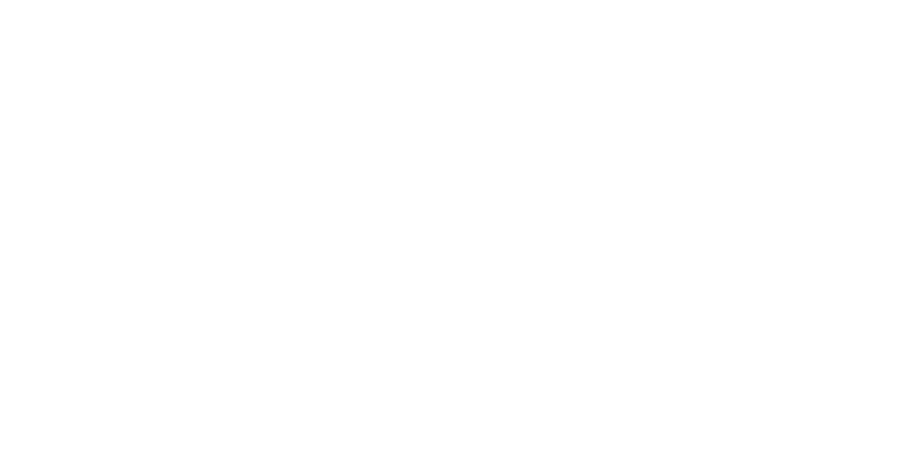

In [18]:
import pearson_correlation_by_duration


Original length of sample data is 4561
110 tests with Result, IPAddress, TotalScore = NaN dropped
Extra ip address dropped in 36 tests


<IPython.core.display.Javascript object>


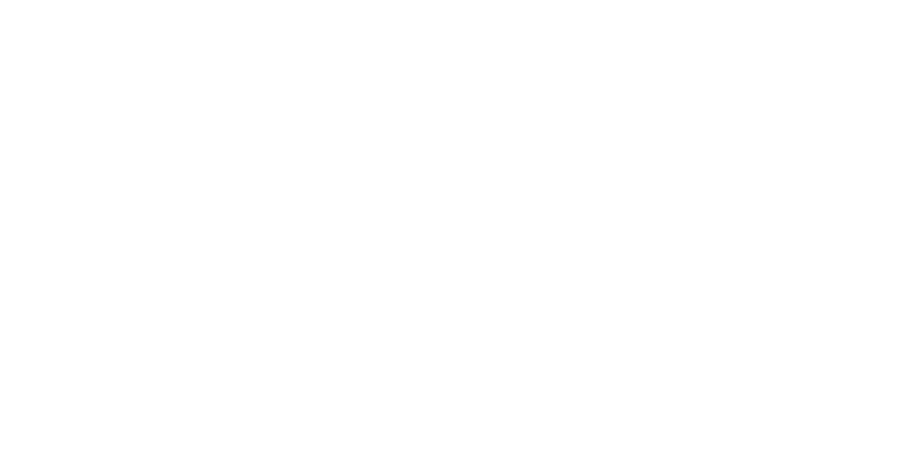

In [19]:
import spearman_correlation_by_duration

In [20]:
import passing_rate

Original length of sample data is 152519
2415 tests with Result, IPAddress, TotalScore = NaN dropped
Extra ip address dropped in 1056 tests


<IPython.core.display.Javascript object>


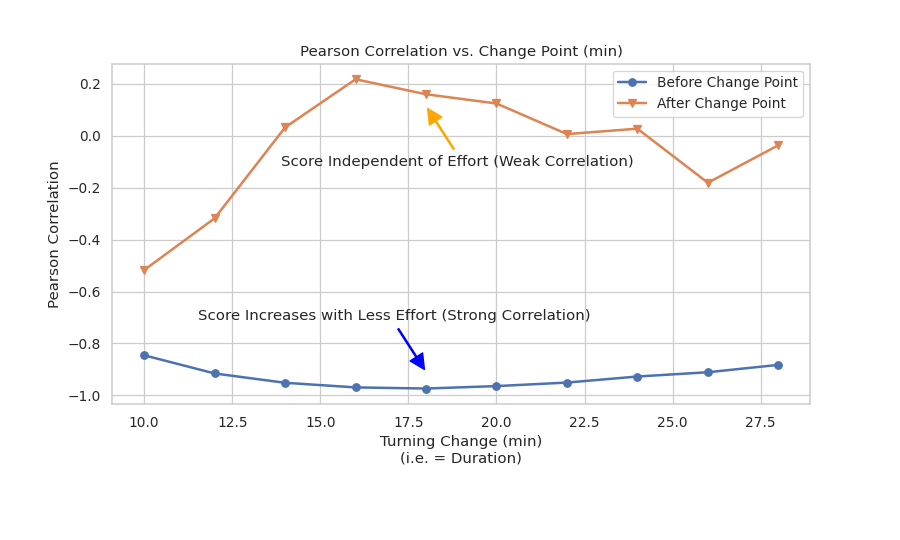

In [36]:
%matplotlib notebook
# Table pearson coefficient for passing rate vs duration midpoint
# Reason: The passing rate below a turning point increases as the
# time to take the test deceases: reward increases with less effort (?).
# But, after before the turning point reward is independent of effort.

import passing_rate as pfs
from scipy.stats import pearsonr
import mplcursors
import matplotlib.pyplot as plt
import pandas as pd
import dmv_test_input as dti

def calc_correlation(pf):
    # Works for duration rate only
    cf = pd.DataFrame(np.arange(10, 30, 2), columns=["midpt"])

    dless = lambda x: pf[pf.duration <  x]
    dmore = lambda x: pf[pf.duration >= x]

    cbefore = lambda x: pearsonr(dless(x).duration, dless(x).duration_rate)[0]
    cafter  = lambda x: pearsonr(dmore(x).duration, dmore(x).duration_rate)[0]

    cf["before_midpt"] = cf.midpt.apply(cbefore)
    cf["after_midpt"]  = cf.midpt.apply(cafter)
    return cf

def plot_correlation_midpoints(df):
    fig, ax = plt.subplots()

    plt.plot(df.midpt, df.before_midpt, "-o", lw=2)
    plt.plot(df.midpt, df.after_midpt, "-v", lw=2)
    
    mplcursors.cursor(hover=True)
    fig.set_size_inches(10, 6)
    fig.subplots_adjust(bottom=.25)
    ax.set_title("Pearson Correlation vs. Change Point (min)")
    ax.set_xlabel("Turning Change (min)\n(i.e. = Duration)")
    ax.set_ylabel("Pearson Correlation")
    ax.legend(["Before Change Point", "After Change Point"])
    
    ax.annotate("Score Increases with Less Effort (Strong Correlation)",
                xy = (18, -.91), xycoords='data',
                xytext=(-25, 50), textcoords='offset points',
                arrowprops=dict(width=1, facecolor='blue', edgecolor='blue', shrink=0.05),
                horizontalalignment='center', verticalalignment='top'
               )
    ax.annotate("Score Independent of Effort (Weak Correlation)",
                xy = (18., .115), xycoords='data',
                xytext=(+25, -50), textcoords='offset points',
                arrowprops=dict(width=1, facecolor='orange', edgecolor="orange", shrink=0.05),
                horizontalalignment='center', verticalalignment='bottom'
               )
    plt.grid(visible=True)
    plt.show()
    
def main():
    df = dti.read_dmv_log(case=2)
#     df, risk = dmv_test_input.dmv_risk_input(case=2)
    df["elapsed"] = abs(df['TestEndDateTime'] - df['TestStartDateTime']).dt.total_seconds()/60.
    df["passed"]  = (df.Result=="P")
    

    limits = pfs.duration_intervals(lo=2.8, hi=40., inc=0.5)
    pf = pfs.passing_rate(df, ['duration'], limits)  

    cf = calc_correlation(pf)
    cf.head()
    plot_correlation_midpoints(cf)
if __name__ == '__main__':
    main()

In [ ]:
df


In [ ]:
df.TestRegistrationDate.max()
